Most network generative models focus on finding the "distribution" of a network that can generate the target network. In other words, the model should be able to generalize the regularity and variability of target network(s). However, up to now we still don't have a good understanding of the regularity and variability of networks even if we have samples of networks. There is no systematic way of analyzing 

Now we have many network generative model that can synthesize networks close to specific network. However, the distribution, especially the variability of networks is still unknown. Here we try to find a method to mimic the process of getting a network distribution close sample of networks.

First, we need to get the network distribution. Let's try to map the resting-state FC networks into the space of *degree* $\times$ *clustering coefficient*

In [5]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import os    # for files IO
import pandas as pd    # for files IO and dataframe
import networkx as nx
import random

from pandas_datareader import data    # for files IO
from scipy.io import loadmat    # for files IO
from sklearn.decomposition import PCA

# function for loading TS
def load_TS(data_loc, subj, sess):
    TS_mat = loadmat(data_loc+'/results_SIFT2/'+subj+'/fMRI/'+sess+'/FC/TSz_glasser_GS_bp_z_subc.mat')
    return TS_mat['TS_merged']

# function for loading FC
def load_FC(data_loc, subj, sess):
    return np.loadtxt(open(data_loc+"/HCP_100S_fMRI_FC/"+subj+"_"+sess+".csv", "rb"), delimiter=",")

# load the data from a random selected subject
data_loc = os.environ['DATA']
subj_list = np.array(os.listdir(data_loc+'/results_SIFT2/'))
sess = 'rfMRI_REST1_LR'
g_stat = np.empty((2,len(subj_list)), dtype=float)

# check if dataset is successfully imported
for i, subj in enumerate(subj_list):
    corrmat = load_FC(data_loc, subj, sess)
    cutoff = 0.2
    corrmat[corrmat < cutoff] = 0
    corrmat[np.eye(corrmat.shape[0],dtype=bool)] = 0
    corrmat[corrmat > 0] = 1
    G=nx.from_numpy_matrix(corrmat)
    g_stat[0,i] = nx.density(G)
    g_stat[1,i] = nx.transitivity(G)

Let's take a look at the distribution of density and transitivity of the graphs.

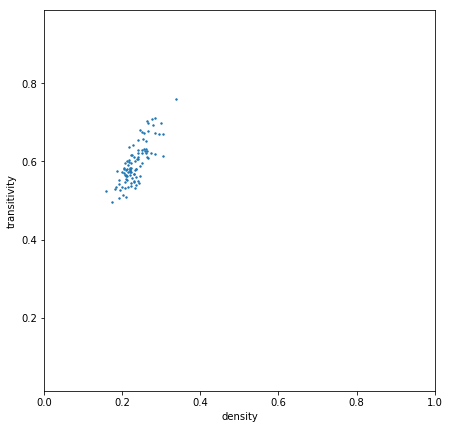

In [6]:
plt.figure(figsize=(7,7))
plt.axis('equal')
plt.axis([0,1,0,1])
plt.xlabel("density")
plt.ylabel("transitivity")
_ = plt.scatter(g_stat[0,:], g_stat[1,:], 2)

Then let's try if we can estimate such distribution by subset of the networks as samples. First, we need to split the subjects into training set and test set.

In [ ]:
subj_ind = np.arange(len(subj_list))
random.shuffle(subj_ind)
train_ind = subj_ind[:int(.5*len(subj_list))]
test_ind = subj_ind[int(.5*len(subj_list)):]

In [ ]:
plt.figure(figsize=(7,7))
plt.axis('equal')
plt.axis([0,1,0,1])
plt.xlabel("density")
plt.ylabel("transitivity")
_ = plt.scatter(g_stat[0,train_ind], g_stat[1,train_ind], 2, 'b')
_ = plt.scatter(g_stat[0,test_ind], g_stat[1,test_ind], 2, 'r')

In [ ]:
# check the mean network of training set
mean_mat = np.zeros_like(corrmat)
for subj_i in train_ind:
    corrmat = load_FC(data_loc, subj_list[subj_i], sess)
    corrmat[corrmat < cutoff] = 0
    corrmat[np.eye(corrmat.shape[0],dtype=bool)] = 0
    corrmat[corrmat > 0] = 1
    mean_mat = mean_mat + corrmat
mean_mat = np.round(mean_mat/len(train_ind))
mean_G=nx.from_numpy_matrix(mean_mat)

In [ ]:
# plot the ``mean'' graph
plt.figure(figsize=(7,7))
plt.axis('equal')
plt.axis([0,1,0,1])
plt.xlabel("density")
plt.ylabel("transitivity")
_ = plt.scatter(g_stat[0,train_ind], g_stat[1,train_ind], 2, 'b')
_ = plt.scatter(nx.density(mean_G), nx.transitivity(mean_G), 10, 'r')

From the plot above, obviously, algebraic mean can't be a good representative of the mean of sample networks(Of course, it would be a good representative of random networks). What if we directly take the average time series and get a correlation matrix?

In [ ]:
ts = np.zeros((360,1200), dtype=float)
for subj in subj_list[train_ind]:
    ts += np.genfromtxt("/data/results_SIFT1/"+subj+"/fMRI/rfMRI_REST1_LR/rfMRI_REST1_LR_glasser_GS_bp_z_tseries.csv", delimiter=',')
corrmat = np.corrcoef(ts[:,5:(ts.shape[1]-5)])
cutoff = 0.2
corrmat[corrmat < cutoff] = 0
corrmat[np.eye(corrmat.shape[0],dtype=bool)] = 0
corrmat[corrmat > 0] = 1
cmean_G = nx.from_numpy_matrix(corrmat)

In [ ]:
# plot the ``mean'' graph
plt.figure(figsize=(7,7))
plt.axis('equal')
plt.axis([0,1,0,1])
plt.xlabel("density")
plt.ylabel("transitivity")
_ = plt.scatter(g_stat[0,train_ind], g_stat[1,train_ind], 2, 'grey')
_ = plt.scatter(nx.density(mean_G), nx.transitivity(mean_G), 10, 'r')
_ = plt.scatter(nx.density(cmean_G), nx.transitivity(cmean_G), 10, 'b')


This can be easily interpreted. The averaged time series will have less variability so the density of the *mean* network will be sparser. Let's try this from a different angel of removing the variability. That might be done by PCA.

In [ ]:
mega_data = np.empty((len(train_ind), int(N*(N-1)/2)))
mega_bin_data = np.empty((len(train_ind), int(N*(N-1)/2)))
for i, subj in enumerate(subj_list[train_ind]):
    corrmat = load_FC(data_loc, subj, sess)
    mega_data[i,:] = corrmat[np.tril_indices(N, k=-1)]
    cutoff = 0.2
    corrmat[corrmat < cutoff] = 0
    corrmat[np.eye(corrmat.shape[0],dtype=bool)] = 0
    corrmat[corrmat > 0] = 1
    mega_bin_data[i,:] = corrmat[np.tril_indices(N, k=-1)]


In [ ]:
pca = PCA(n_components=50)
pca.fit(mega_data)
trans_data = pca.inverse_transform(pca.fit_transform(mega_data))
trans_g_stat = np.empty((2,len(train_ind)), dtype=float)

plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [ ]:
pca = PCA(n_components=1)
pca.fit(mega_data)
trans_data = pca.inverse_transform(pca.fit_transform(mega_data))
trans_g_stat = np.empty((2,len(train_ind)), dtype=float)

for i, subj in enumerate(subj_list[train_ind]):
    corrmat = mat_from_list(np.transpose(trans_data[i,:]))
    cutoff = 0.2
    corrmat[corrmat < cutoff] = 0
    corrmat[np.eye(corrmat.shape[0],dtype=bool)] = 0
    corrmat[corrmat > 0] = 1
    G = nx.from_numpy_matrix(corrmat)
    trans_g_stat[0,i] = nx.density(G)
    trans_g_stat[1,i] = nx.transitivity(G)
    
# plot the ``mean'' graph
plt.figure(figsize=(7,7))
plt.axis('equal')
plt.axis([0,1,0,1])
plt.xlabel("density")
plt.ylabel("transitivity")
plt.xlim(0,.5)
plt.ylim(.3, .8)
_ = plt.scatter(g_stat[0,train_ind], g_stat[1,train_ind], 2, 'b')
_ = plt.scatter(nx.density(mean_G), nx.transitivity(mean_G), 30, 'c', 'x')
_ = plt.scatter(nx.density(cmean_G), nx.transitivity(cmean_G), 30, 'm', 'x')
_ = plt.scatter(trans_g_stat[0,:], trans_g_stat[1,:], 2, 'r')


In [ ]:
pca = PCA(n_components=30)
pca.fit(mega_data)
trans_data = pca.inverse_transform(pca.fit_transform(mega_data))
trans_g_stat = np.empty((2,len(train_ind)), dtype=float)

for i, subj in enumerate(subj_list[train_ind]):
    corrmat = mat_from_list(np.transpose(trans_data[i,:]))
    cutoff = 0.2
    corrmat[corrmat < cutoff] = 0
    corrmat[np.eye(corrmat.shape[0],dtype=bool)] = 0
    corrmat[corrmat > 0] = 1
    G = nx.from_numpy_matrix(corrmat)
    trans_g_stat[0,i] = nx.density(G)
    trans_g_stat[1,i] = nx.transitivity(G)
    
# plot the ``mean'' graph
plt.figure(figsize=(7,7))
plt.axis('equal')
plt.axis([0,1,0,1])
plt.xlabel("density")
plt.ylabel("transitivity")
plt.xlim(0,.5)
plt.ylim(.3, .8)
_ = plt.scatter(g_stat[0,train_ind], g_stat[1,train_ind], 2, 'b')
_ = plt.scatter(nx.density(mean_G), nx.transitivity(mean_G), 30, 'c', 'x')
_ = plt.scatter(nx.density(cmean_G), nx.transitivity(cmean_G), 30, 'm', 'x')
_ = plt.scatter(trans_g_stat[0,:], trans_g_stat[1,:], 2, 'r')


So we are curious if we can capture the variance. Let's check the distribution of the variance.

In [ ]:
pca = PCA(n_components=50)
pca.fit(mega_bin_data)
trans_data = pca.inverse_transform(pca.fit_transform(mega_bin_data))
trans_g_stat = np.empty((2,len(train_ind)), dtype=float)

